<a href="https://colab.research.google.com/github/TonyIssacJames/eva04_mar_2020_public/blob/master/Assignment_05_trial/EVA4S5F1_setup_runall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


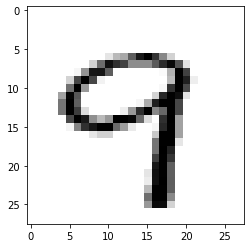

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

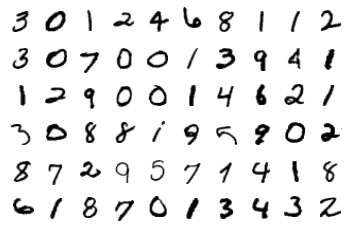

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model 01
Let's start with the model we first saw

In [0]:
class Net_01(nn.Module):
    def __init__(self):
        super(Net_01, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 02

- we are trying to get a skeletorn here

In [0]:
class Net_02(nn.Module):
    def __init__(self):
        super(Net_02, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 03

- Trim the model as much as possible, keeping the structure same

In [0]:
class Net_03(nn.Module):
    def __init__(self):
        super(Net_03, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 04

- same parameters as Model 03 (except BN added some parameters)
- increase capacity
- added Batch Normalisation

In [0]:
class Net_04(nn.Module):
    def __init__(self):
        super(Net_04, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 05

- same as Model 04 except for dropout
- same number of parameters as Model 04
- dropout is only added to two layers not to every layer

In [0]:
class Net_05(nn.Module):
    def __init__(self):
        super(Net_05, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 06

- removed FCL with GAP
- parameter reduced to 6070
- the accuracy reduces because of two reason
    - there should be a layer after GAP
    - we comparing n/w with 6070 parameters with a n/w with 10970 parameters

In [0]:
class Net_06(nn.Module):
    def __init__(self):
        super(Net_06, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 07

- the skelton is same as Model 06 but added more kernels

- the Model 06 has the following problems due to which
    - the accuracy reduces because of two reason
      - there should be a layer after GAP
      - we comparing n/w with 6070 parameters with a n/w with 10970 parameters (Fixed IT w/o chaning skeleton)

In [0]:
class Net_07(nn.Module):
    def __init__(self):
        super(Net_07, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model 08

- the skelton is same as Model 06/07 but added some 1x1 kernels as transition layers

- changed position of maxpooling
- added dropout everywhere (Conv, Relu, BN, Dropout)
- added a layer after GAP

In [0]:
dropout_value = 0.1
class Net_08(nn.Module):
    def __init__(self):
        super(Net_08, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#Model 09

- Model 09 is ditto as Model 08

- while running Model 09 we just Image Augmentation

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net_09(nn.Module):
    def __init__(self):
        super(Net_09, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


## Model 01 parameters

In [18]:

Net_Array=[Net_01, Net_02, Net_03, Net_04, Net_05, Net_06, Net_07, Net_08]

for i, Net_X in enumerate(Net_Array):
  print("Model_0"+str(i + 1),":  Summary")
  model = Net_X().to(device)
  summary(model, input_size=(1, 28, 28))
  for n in range(5):
    print()

Model_01 :  Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-----------------

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [20]:
Net_Array=[Net_01, Net_02, Net_03, Net_04, Net_05, Net_06, Net_07, Net_08]

for i, Net_X in enumerate(Net_Array):
  print("Model_0"+str(i + 1),":  Training + Testing")
  model = Net_X().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 12

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  for n in range(5):
    print()

Model_01 :  Training + Testing


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.036724165081977844 Batch_id=468 Accuracy=85.86: 100%|██████████| 469/469 [00:12<00:00, 38.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Test Accuracy: 9823/10000 (98.23%)

EPOCH: 1


Loss=0.015382066369056702 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:11<00:00, 39.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Test Accuracy: 9886/10000 (98.86%)

EPOCH: 2


Loss=0.0394490621984005 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:11<00:00, 39.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Test Accuracy: 9892/10000 (98.92%)

EPOCH: 3


Loss=0.016363149508833885 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 38.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Test Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.02125496231019497 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.004873851779848337 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.03870294988155365 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:12<00:00, 38.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.0008910298347473145 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:12<00:00, 38.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.0015505006304010749 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:12<00:00, 38.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.0006388425827026367 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:12<00:00, 38.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.0002878209052141756 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:12<00:00, 39.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.00010872880375245586 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:12<00:00, 38.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Test Accuracy: 9919/10000 (99.19%)






Model_02 :  Training + Testing
EPOCH: 0


Loss=0.13317514955997467 Batch_id=468 Accuracy=62.93: 100%|██████████| 469/469 [00:09<00:00, 47.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1810, Test Accuracy: 9441/10000 (94.41%)

EPOCH: 1


Loss=0.04976833984255791 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:09<00:00, 48.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Test Accuracy: 9756/10000 (97.56%)

EPOCH: 2


Loss=0.015403558500111103 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:09<00:00, 48.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Test Accuracy: 9808/10000 (98.08%)

EPOCH: 3


Loss=0.02988150715827942 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:09<00:00, 48.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Test Accuracy: 9824/10000 (98.24%)

EPOCH: 4


Loss=0.039238471537828445 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:09<00:00, 48.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Test Accuracy: 9840/10000 (98.40%)

EPOCH: 5


Loss=0.027644088491797447 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:09<00:00, 47.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Test Accuracy: 9827/10000 (98.27%)

EPOCH: 6


Loss=0.047964323312044144 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:09<00:00, 48.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Test Accuracy: 9850/10000 (98.50%)

EPOCH: 7


Loss=0.0630742758512497 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:10<00:00, 46.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Test Accuracy: 9867/10000 (98.67%)

EPOCH: 8


Loss=0.028324568644165993 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:09<00:00, 47.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Test Accuracy: 9877/10000 (98.77%)

EPOCH: 9


Loss=0.009864513762295246 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:09<00:00, 47.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Test Accuracy: 9884/10000 (98.84%)

EPOCH: 10


Loss=0.008588433265686035 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:09<00:00, 47.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Test Accuracy: 9878/10000 (98.78%)

EPOCH: 11


Loss=0.005201905965805054 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:09<00:00, 48.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9872/10000 (98.72%)






Model_03 :  Training + Testing
EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2838, Test Accuracy: 3658/10000 (36.58%)

EPOCH: 1


Loss=0.19252179563045502 Batch_id=468 Accuracy=86.23: 100%|██████████| 469/469 [00:09<00:00, 51.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1774, Test Accuracy: 9423/10000 (94.23%)

EPOCH: 2


Loss=0.08046520501375198 Batch_id=468 Accuracy=95.22: 100%|██████████| 469/469 [00:09<00:00, 49.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1047, Test Accuracy: 9652/10000 (96.52%)

EPOCH: 3


Loss=0.06515876203775406 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:09<00:00, 50.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0701, Test Accuracy: 9771/10000 (97.71%)

EPOCH: 4


Loss=0.08926678448915482 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:09<00:00, 50.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Test Accuracy: 9802/10000 (98.02%)

EPOCH: 5


Loss=0.03400464355945587 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:09<00:00, 50.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Test Accuracy: 9845/10000 (98.45%)

EPOCH: 6


Loss=0.05968068167567253 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:09<00:00, 50.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Test Accuracy: 9819/10000 (98.19%)

EPOCH: 7


Loss=0.056425612419843674 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:09<00:00, 50.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Test Accuracy: 9845/10000 (98.45%)

EPOCH: 8


Loss=0.01564578153192997 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:09<00:00, 50.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Test Accuracy: 9857/10000 (98.57%)

EPOCH: 9


Loss=0.018326714634895325 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:09<00:00, 50.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9872/10000 (98.72%)

EPOCH: 10


Loss=0.02178555727005005 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:09<00:00, 49.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Test Accuracy: 9855/10000 (98.55%)

EPOCH: 11


Loss=0.04681547358632088 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:09<00:00, 50.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Test Accuracy: 9871/10000 (98.71%)






Model_04 :  Training + Testing
EPOCH: 0


Loss=0.03542134538292885 Batch_id=468 Accuracy=94.81: 100%|██████████| 469/469 [00:09<00:00, 47.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Test Accuracy: 9838/10000 (98.38%)

EPOCH: 1


Loss=0.06943892687559128 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:09<00:00, 47.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9883/10000 (98.83%)

EPOCH: 2


Loss=0.01300753653049469 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:09<00:00, 47.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Test Accuracy: 9888/10000 (98.88%)

EPOCH: 3


Loss=0.07280126959085464 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:09<00:00, 47.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Test Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.021642183884978294 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:09<00:00, 47.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Test Accuracy: 9889/10000 (98.89%)

EPOCH: 5


Loss=0.004173651337623596 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:10<00:00, 46.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Test Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.012517969124019146 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:09<00:00, 47.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.03725746273994446 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:09<00:00, 47.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.009470676071941853 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:09<00:00, 47.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.008095641620457172 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:09<00:00, 47.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 10


Loss=0.023266682401299477 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:09<00:00, 47.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.015565499663352966 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:09<00:00, 47.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Test Accuracy: 9905/10000 (99.05%)






Model_05 :  Training + Testing
EPOCH: 0


Loss=0.09639403223991394 Batch_id=468 Accuracy=92.44: 100%|██████████| 469/469 [00:10<00:00, 44.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0900, Test Accuracy: 9753/10000 (97.53%)

EPOCH: 1


Loss=0.11003427952528 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:10<00:00, 46.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Test Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.08962827175855637 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:09<00:00, 47.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Test Accuracy: 9828/10000 (98.28%)

EPOCH: 3


Loss=0.008775666356086731 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:09<00:00, 47.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Test Accuracy: 9852/10000 (98.52%)

EPOCH: 4


Loss=0.021810417994856834 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:09<00:00, 47.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Test Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.0385809950530529 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:10<00:00, 46.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Test Accuracy: 9878/10000 (98.78%)

EPOCH: 6


Loss=0.01817178726196289 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:10<00:00, 46.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Test Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.02023899555206299 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:10<00:00, 46.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Test Accuracy: 9891/10000 (98.91%)

EPOCH: 8


Loss=0.0428764782845974 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:09<00:00, 47.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Test Accuracy: 9876/10000 (98.76%)

EPOCH: 9


Loss=0.09821153432130814 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:09<00:00, 47.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Test Accuracy: 9902/10000 (99.02%)

EPOCH: 10


Loss=0.015135089866816998 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:09<00:00, 46.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Test Accuracy: 9898/10000 (98.98%)

EPOCH: 11


Loss=0.024065926671028137 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:09<00:00, 47.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Test Accuracy: 9904/10000 (99.04%)






Model_06 :  Training + Testing
EPOCH: 0


Loss=0.26243963837623596 Batch_id=468 Accuracy=81.96: 100%|██████████| 469/469 [00:09<00:00, 47.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6690, Test Accuracy: 8343/10000 (83.43%)

EPOCH: 1


Loss=0.14618909358978271 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:09<00:00, 47.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2912, Test Accuracy: 9361/10000 (93.61%)

EPOCH: 2


Loss=0.09385862946510315 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:09<00:00, 46.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3248, Test Accuracy: 9194/10000 (91.94%)

EPOCH: 3


Loss=0.09931459277868271 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:10<00:00, 46.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1772, Test Accuracy: 9624/10000 (96.24%)

EPOCH: 4


Loss=0.09168043732643127 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:09<00:00, 47.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1629, Test Accuracy: 9607/10000 (96.07%)

EPOCH: 5


Loss=0.09752773493528366 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:09<00:00, 47.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1704, Test Accuracy: 9554/10000 (95.54%)

EPOCH: 6


Loss=0.09042263776063919 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:09<00:00, 47.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1956, Test Accuracy: 9463/10000 (94.63%)

EPOCH: 7


Loss=0.0790858045220375 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:09<00:00, 47.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1186, Test Accuracy: 9708/10000 (97.08%)

EPOCH: 8


Loss=0.026218673214316368 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:09<00:00, 47.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1101, Test Accuracy: 9716/10000 (97.16%)

EPOCH: 9


Loss=0.06359375268220901 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:09<00:00, 47.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1035, Test Accuracy: 9756/10000 (97.56%)

EPOCH: 10


Loss=0.020274624228477478 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:09<00:00, 47.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0980, Test Accuracy: 9746/10000 (97.46%)

EPOCH: 11


Loss=0.057734932750463486 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:09<00:00, 47.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1043, Test Accuracy: 9742/10000 (97.42%)






Model_07 :  Training + Testing
EPOCH: 0


Loss=0.08580091595649719 Batch_id=468 Accuracy=84.33: 100%|██████████| 469/469 [00:09<00:00, 47.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2312, Test Accuracy: 9381/10000 (93.81%)

EPOCH: 1


Loss=0.08162246644496918 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:09<00:00, 46.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1011, Test Accuracy: 9715/10000 (97.15%)

EPOCH: 2


Loss=0.09243344515562057 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:09<00:00, 47.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Test Accuracy: 9798/10000 (97.98%)

EPOCH: 3


Loss=0.04505652189254761 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:09<00:00, 47.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0836, Test Accuracy: 9766/10000 (97.66%)

EPOCH: 4


Loss=0.037480566650629044 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:10<00:00, 46.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0687, Test Accuracy: 9816/10000 (98.16%)

EPOCH: 5


Loss=0.03371113911271095 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:09<00:00, 46.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Test Accuracy: 9869/10000 (98.69%)

EPOCH: 6


Loss=0.027400249615311623 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:09<00:00, 47.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Test Accuracy: 9840/10000 (98.40%)

EPOCH: 7


Loss=0.00328913819976151 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:09<00:00, 47.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Test Accuracy: 9802/10000 (98.02%)

EPOCH: 8


Loss=0.04486384615302086 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:09<00:00, 46.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Test Accuracy: 9823/10000 (98.23%)

EPOCH: 9


Loss=0.09373945742845535 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:10<00:00, 45.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Test Accuracy: 9883/10000 (98.83%)

EPOCH: 10


Loss=0.011564304120838642 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:10<00:00, 46.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Test Accuracy: 9870/10000 (98.70%)

EPOCH: 11


Loss=0.03221161663532257 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 46.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Test Accuracy: 9880/10000 (98.80%)






Model_08 :  Training + Testing
EPOCH: 0


Loss=0.09567725658416748 Batch_id=468 Accuracy=87.14: 100%|██████████| 469/469 [00:09<00:00, 46.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0825, Test Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Loss=0.029045546427369118 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:09<00:00, 46.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Test Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.05997629091143608 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:09<00:00, 47.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 3


Loss=0.019762316718697548 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:09<00:00, 47.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Test Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.10828986018896103 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:09<00:00, 47.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Test Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.04225822165608406 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:09<00:00, 47.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.024975528940558434 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:10<00:00, 46.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.007719611283391714 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:10<00:00, 46.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Test Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.017659038305282593 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:10<00:00, 46.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.05242535099387169 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:09<00:00, 46.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.01815297268331051 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:09<00:00, 46.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.012158329598605633 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:09<00:00, 47.52it/s]



Test set: Average loss: 0.0265, Test Accuracy: 9927/10000 (99.27%)








Text(0.5, 1.0, 'Test Accuracy')

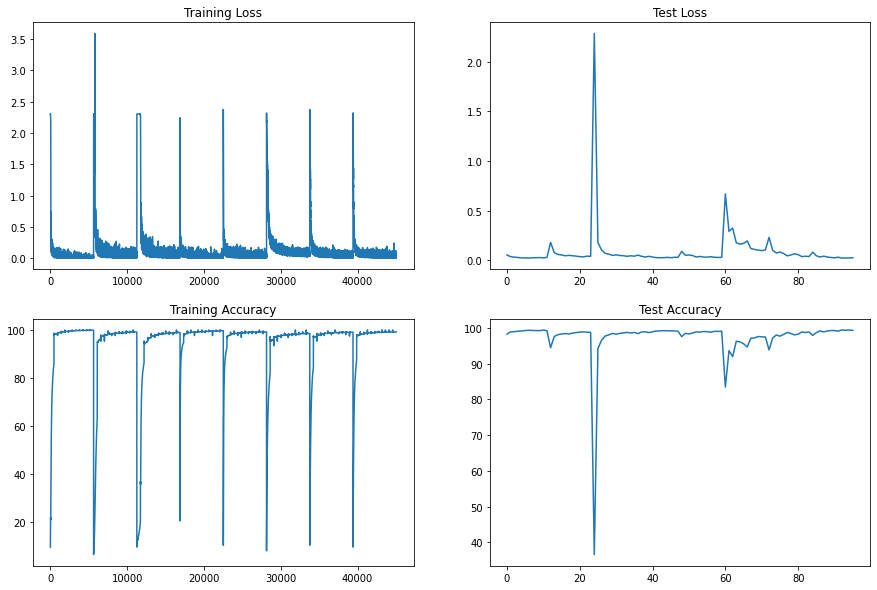

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")